## Projecct 2 Part 3A - EDA

*Christina Brockway*

#### Business Issues

-  Use TMDB database
-  Extract budget, revenue, and MPAA Rating (Certification) data
-  Perform test extraction on movies from 2001 and 2002
-  Combine final API data into 1 dataframe
-  Create visualiztions to answer questions

### Imports

In [1]:
#Import packages
import os, time, json
import tmdbsimple as tmdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm_notebook

#Set configs
pd.set_option('display.max_column', None)

### Define custom functions


In [2]:
# Explore Categorical Data

def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Source: https://login.codingdojo.com/m/606/13765/117604"""
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  #Labels for barplot values
  for container in ax.containers:
      ax.bar_label(container)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax



*Source for barplot labels:  https://stackoverflow.com/questions/55104819/display-count-on-top-of-seaborn-barplot*

In [3]:
# Updated plot_categorical_vs_target function that includes option for classification task
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax


### Load data

In [4]:
df2001=pd.read_csv("MovieData/final_tmdb_data_2001.csv.gz")
df2001.head(2)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/tJLV3BAlHOgscVOrA99Wnb2gAef.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,When her scientist ex-boyfriend discovers a po...,13.382,/mUvikzKJJSg9khrVdxK8kg3TMHA.jpg,"[{'id': 85, 'logo_path': None, 'name': 'Konrad...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-12-25,76019048.0,118.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.319,1238.0,PG-13


In [5]:
df2002=pd.read_csv("MovieData/final_tmdb_data_2002.csv.gz")
df2002.head(2)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0096056,0.0,/95U3MUDXu4xSCmVLtWgargRipDi.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,109809.0,en,Crime and Punishment,A modern day adaptation of Dostoyevsky's class...,4.119,/2ckMQwDi11TofiNoaE3sHrYbaCh.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2002-06-01,0.0,126.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Crime and Punishment,0.0,5.3,12.0,NaN


In [6]:
df_to_combine = [df2001, df2001]
df = pd.concat(df_to_combine)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2716 entries, 0 to 1357
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2716 non-null   object 
 1   adult                  2714 non-null   float64
 2   backdrop_path          1494 non-null   object 
 3   belongs_to_collection  194 non-null    object 
 4   budget                 2714 non-null   float64
 5   genres                 2714 non-null   object 
 6   homepage               214 non-null    object 
 7   id                     2714 non-null   float64
 8   original_language      2714 non-null   object 
 9   original_title         2714 non-null   object 
 10  overview               2660 non-null   object 
 11  popularity             2714 non-null   float64
 12  poster_path            2454 non-null   object 
 13  production_companies   2714 non-null   object 
 14  production_countries   2714 non-null   object 
 15  rele

### Inspect the Data

In [7]:
df.head(5)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/tJLV3BAlHOgscVOrA99Wnb2gAef.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,When her scientist ex-boyfriend discovers a po...,13.382,/mUvikzKJJSg9khrVdxK8kg3TMHA.jpg,"[{'id': 85, 'logo_path': None, 'name': 'Konrad...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-12-25,76019048.0,118.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.319,1238.0,PG-13
2,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,An elite Federal force whose objective is to e...,2.612,/u0njmfXD3dXxQfeykBHBuFQOYqD.jpg,[],[],2001-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.000,3.0,NaN
3,tt0116916,0.0,/rFpHBidSlhjflmnLu7BZilyKeQR.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,73549.0,en,The Dark Mist,With the future of the world hanging in the ba...,2.744,/z18E0lukzOtAALmfINSTCUU0Als.jpg,"[{'id': 71364, 'logo_path': None, 'name': 'Car...","[{'iso_3166_1': 'US', 'name': 'United States o...",1996-01-01,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Dark Mist,0.0,3.500,2.0,PG
4,tt0118589,0.0,/9NZAirJahVilTiDNCHLFcdkwkiy.jpg,NaN,22000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696.0,en,Glitter,"A young woman is catapulted into pop stardom, ...",7.460,/b8gKsXB6d60SC2HKUcAAzTacn0S.jpg,"[{'id': 89627, 'logo_path': None, 'name': 'Gli...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-09-21,5271666.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"In music she found her dream, her love, herself.",Glitter,0.0,4.405,132.0,PG-13


In [8]:
#Display the number of rows and columns
df.shape

(2716, 26)

In [9]:
# Desplay statistics
df.describe()


,adult,budget,id,popularity,revenue,runtime,video,vote_average,vote_count
count,2714.000000,2.714000e+03,2.714000e+03,2714.000000,2.714000e+03,2714.000000,2714.000000,2714.000000,2714.000000
mean,0.001474,5.137003e+06,1.865741e+05,5.686727,1.136507e+07,94.294031,0.000737,4.587865,301.765660
std,0.038369,1.687682e+07,2.407408e+05,10.961388,5.764860e+07,27.832892,0.027141,2.467790,1519.754213
min,0.000000,0.000000e+00,1.200000e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,2.714900e+04,1.341000,0.000000e+00,88.000000,0.000000,3.400000,1.000000
50%,0.000000,0.000000e+00,7.923600e+04,2.346000,0.000000e+00,94.000000,0.000000,5.368000,7.000000
75%,0.000000,0.000000e+00,2.755860e+05,5.603000,0.000000e+00,105.000000,0.000000,6.319000,42.000000
max,1.000000,1.400000e+08,1.194037e+06,165.562000,9.764756e+08,301.000000,1.000000,10.000000,25542.000000


In [10]:
#Display non-null values and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2716 entries, 0 to 1357
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2716 non-null   object 
 1   adult                  2714 non-null   float64
 2   backdrop_path          1494 non-null   object 
 3   belongs_to_collection  194 non-null    object 
 4   budget                 2714 non-null   float64
 5   genres                 2714 non-null   object 
 6   homepage               214 non-null    object 
 7   id                     2714 non-null   float64
 8   original_language      2714 non-null   object 
 9   original_title         2714 non-null   object 
 10  overview               2660 non-null   object 
 11  popularity             2714 non-null   float64
 12  poster_path            2454 non-null   object 
 13  production_companies   2714 non-null   object 
 14  production_countries   2714 non-null   object 
 15  rele

## Exploratory Data Analysis

### Questions:

**How many movies had at least some valid financial information?**
-  values >0 for budget and/or >0 for revenue
-  There are 626

In [11]:
df_budget = df.loc[(df['budget']>0 )| (df["revenue"])]

df_budget.shape

(696, 26)

**How many movies are there in each of the certification categories?**

-  There are 242 movies with missing certification
-  143 movies are rated PG-13
-  31 movies are rated PG
-  14 movies are rated G
-  20 movies are NR
-  242 movies are rated R

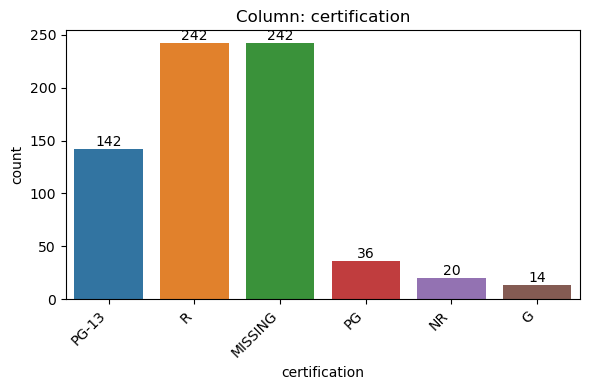

- NaN's Found: 242 (34.77%)
- Unique Values: 6
- Most common value: 'R' occurs 242 times (34.77%)
- Not constant or quasi-constant.


In [12]:
explore_categorical(df_budget, 'certification');

*Source:  https://stackoverflow.com/questions/30482071/how-to-calculate-mean-values-grouped-on-another-column*

**What is the average revenue per certification category?**

In [13]:
df.groupby('certification', as_index=False)['revenue'].mean()

,certification,revenue
0,G,8.342969e+07
1,NC-17,0.000000e+00
2,NR,1.613498e+06
3,PG,7.566910e+07
4,PG-13,7.021975e+07
5,R,1.749135e+07


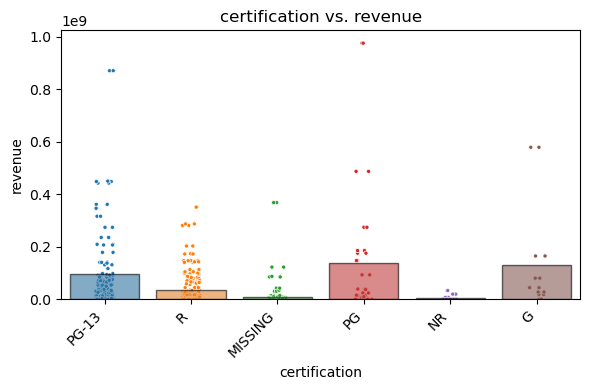

In [14]:
x='certification'
y='revenue'
plot_categorical_vs_target(df_budget, x,y);

**What is the average budget per certification category?**

In [15]:
df.groupby('certification', as_index=False)['budget'].mean()

,certification,budget
0,G,1.927273e+07
1,NC-17,0.000000e+00
2,NR,4.603948e+05
3,PG,2.318476e+07
4,PG-13,2.975678e+07
5,R,1.022164e+07


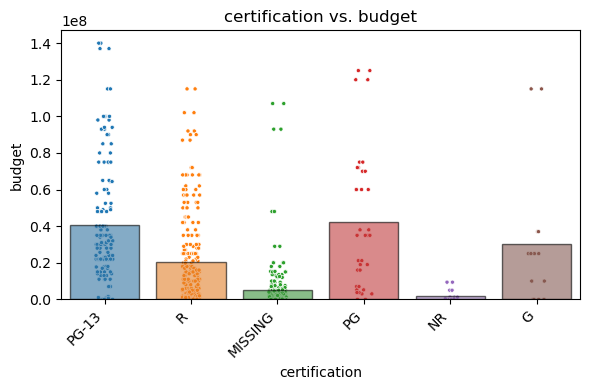

In [16]:
x='certification'
y='budget'
plot_categorical_vs_target(df_budget, x,y);

In [17]:
# Save dataframe
df_budget.to_csv(f"MovieData/tmdb_results_combined.csv.gz", 
                                   compression='gzip', index=False)